<center><h1>Ejercicio - Clasificación desde Machine Learning</h1></center>

En esta sesión trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:


- [default]: Variable binaria. Registra si el cliente entró en morosidad o no.
- [student]: Variable binaria. Registra si el cliente es estudiante o no.
- [balance]: Total de saldo en la cuenta de crédito.
- [income]: Ingreso promedio declarado por el cliente.

<center><h2>Parte 1: Preparación del ambiente de trabajo</h2></center>

- Importe los módulos básicos para el análisis de datos
- Importe `seaborn`.
- Importe `statsmodels`.
- Importe `LogisticRegression`, `train_test_split`, `StandardScaler`, `classification_report` y `roc_curve de sklearn`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
plt.rcParams["figure.figsize"] = (6,4) 
plt.rcParams["figure.dpi"] = 100 

In [2]:
df = pd.read_csv("default_credit.csv")
df = df.drop(columns = "index")

<center><h2>Parte 2: Análisis exploratorio</h2></center>

- Explore las principales relaciones entre las variables. Utilizando los métodos `boxplot` y `lmplot` de seaborn implemente los siguientes gráficos.
  - Un boxplot del balance total de las cuentas, segmentado por el status de estudiante.
  - Un boxplot del ingreso total de cada cliente, segmentado por el status de estudiante.
  - Un boxplot del balance total de las cuentas, segmentado por el status de default.
  - Un boxplot del ingreso total de cada cliente, segmentado por el status de default.
  - Un diagrama de dispersión entre balance e income, segmentado por el status de estudiante.
  - Un diagrama de dispersión entre balance e income, segmentado por el status de default.
- Comente brevemente sobre los principales patrones de comportamiento.
  - **tip**: Puede utilizar el argumento hue en lmplot para identificar las observaciones por status.


In [3]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


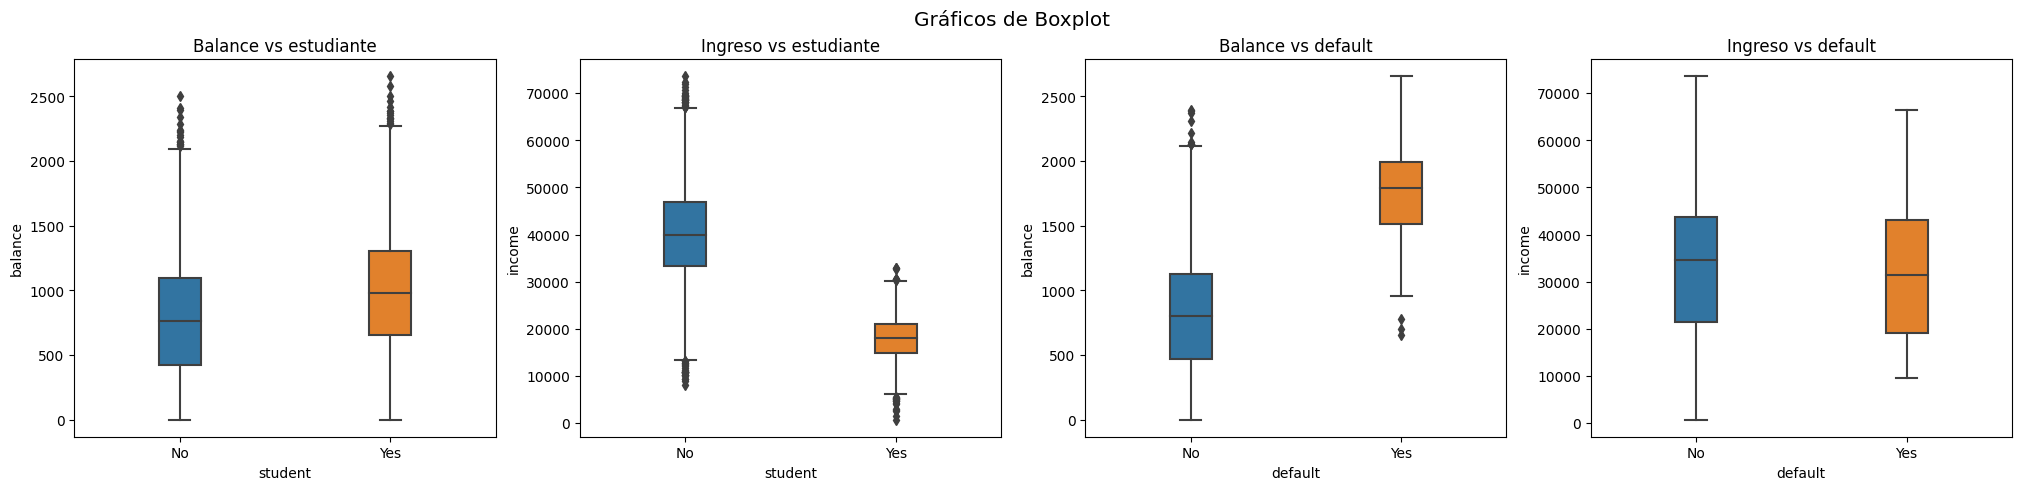

In [4]:
plt.figure(figsize = (25,5))
plt.subplot(1, 4, 1)
sns.boxplot(x='student', y='balance', data=df, width=0.2)
plt.title('Balance vs estudiante')
plt.subplot(1, 4, 2)
sns.boxplot(x='student', y='income', data=df, width=0.2)
plt.title('Ingreso vs estudiante')
plt.subplot(1, 4, 3)
sns.boxplot(x='default', y='balance', data=df, width=0.2)
plt.title('Balance vs default')
plt.subplot(1, 4, 4)
sns.boxplot(x='default', y='income', data=df, width=0.2)
plt.title('Ingreso vs default')
plt.suptitle('Gráficos de Boxplot', fontsize='x-large')
plt.show()

Con los boxplot podemos deducir que:

 1. Balance vs estudiante: Aunque existe una diferencia entre los balances, si es o no es estudiante no pareciera mostrar una diferencia muy grande en el balance de la cuenta.
 
 2. Ingreso vs estudiante: Se ve que al ser estudiante se obtiene un menor ingreso, lo cual es logico.

 3. Balance vs default: Se ve un aumento del balance de la cuenta si el cliente tiene morosidad.
 
 4. Ingreso vs default: Si el cuente tiene o no tiene morosidad no parece inferir en el Ingreso del cliente. lo cual tambien nos parece logico. Aunque al no tener mora, los ingresos se ven un poco mas altos y mas dispersos.

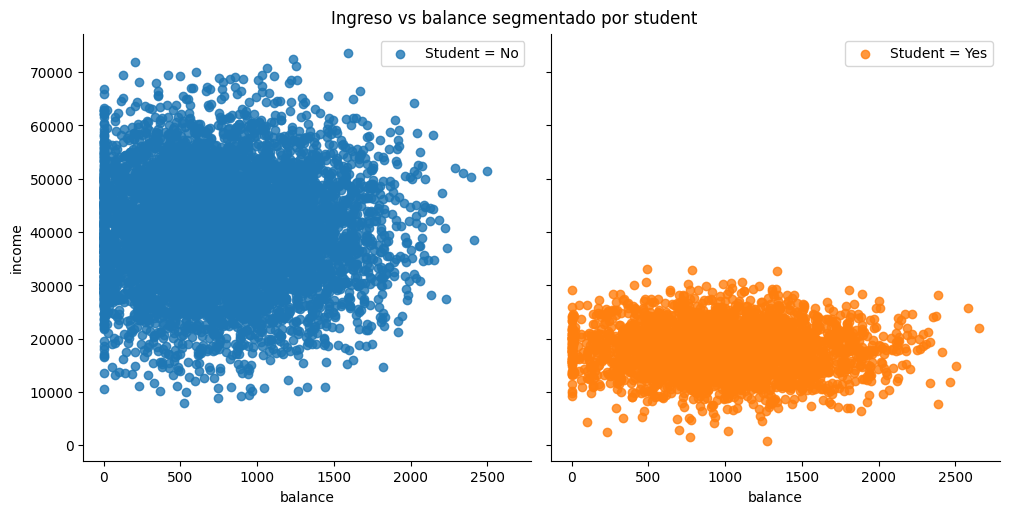

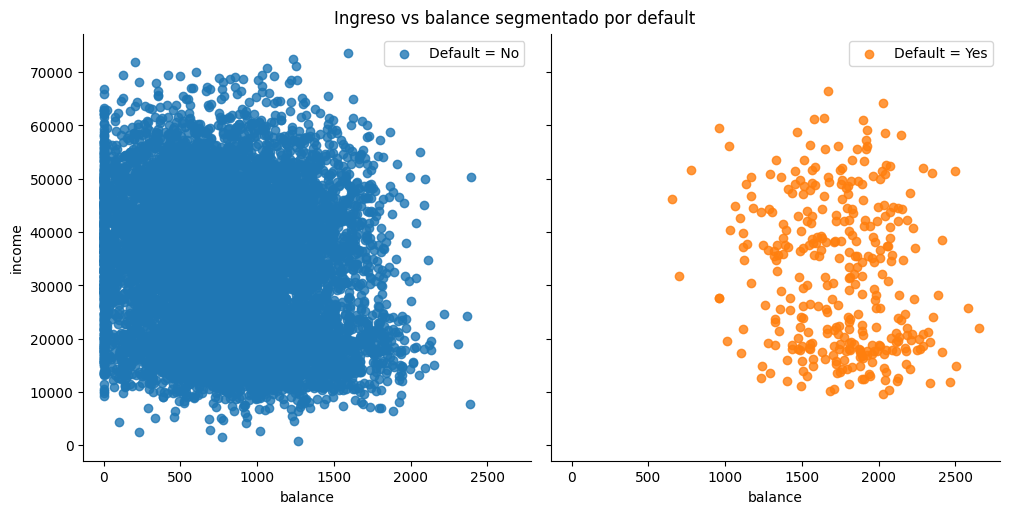

In [5]:
g1 = sns.lmplot(x='balance', y='income', data=df, hue='student', col='student', fit_reg=False)
g1.fig.axes[0].set(title='')
g1.fig.axes[0].legend(['Student = No'])
g1.fig.axes[1].set(title='')
g1.fig.axes[1].legend(['Student = Yes'])
plt.suptitle('Ingreso vs balance segmentado por student')
g2 = sns.lmplot(x='balance', y='income', data=df, hue='default', col='default', fit_reg=False)
g2.fig.axes[0].set(title='')
g2.fig.axes[0].legend(['Default = No'])
g2.fig.axes[1].set(title='')
g2.fig.axes[1].legend(['Default = Yes'])
plt.suptitle('Ingreso vs balance segmentado por default')
plt.show()

Aca separamos los graficos solo para ver si se entendian mejor por separado, pero uno al lado del otro. A nosotros nos parece mas facil visualizar las diferencias de los datos de esta manera por sobre mostrar las dispersiones en un solo grafico con los puntos de colores.

En ambos graficos de 'No' (azules) vemos que existen mas cuentas con valores 0 y la dispersion de datos se parecen mucho por lo que podemos inferir que el no estar estdiando o no tener morosidad pareciera no tener una diferecia significativa.

Para los 'Yes' (naranjo) vemos mas diferencias, primero en 'student' se ve que el balance esta mas o menos bien disperso, pero el 'income' es mas bajo que para los que no estan estudiando.

Para los morosos, se ve que son menores, y aunque el ingreso de ellos no pareciera mostrar nada anomalo, si vemos que el balance de sus cuentas es mayor.

<center><h2>Parte 3: Modelación econométrica</h2></center>

- Recodifique las variables student y default para que adquieran atributos numéricos.
- Implemente el siguiente modelo econométrico:
$$\log\left(\frac{\text{Pr}(\text{default}=1)}{1-\text{Pr}(\text{default}=1)}\right)=\beta_0+\beta_1\cdot\text{balance}+\beta_2\cdot\text{income}+\beta_3\cdot\text{student}$$
- A partir de este modelo, depúrelo y mantenga las principales características. Ejecute de nuevo el modelo y comente brevemente sobre el comportamiento de los atributos.


In [6]:
for i in df:
    if df[i].dtype == np.float64 or df[i].dtype == np.int64:
        media = df[i].dropna().mean(); var = df[i].dropna().var()
        df[f"z_{i}"] = (df[i] - media)/var
    else:
        df[f"binarize_{i}"] = np.where(df[i] == "Yes", 1, 0)

In [7]:
model_logit = smf.logit('binarize_default ~ balance + income + binarize_student', df).fit()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


In [8]:
model_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       binarize_default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 May 2021   Pseudo R-squ.:                  0.4619
Time:                        21:35:24   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance              0.0057      0.000     24.737      0.000       0.005       0.006
income            3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05
binarize_student    -0.6468      0.236     -2.738      0.006      -1.110      -0.184
====================================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [9]:
model_logit_debug = smf.logit('binarize_default ~ balance + binarize_student', df).fit()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


In [10]:
model_logit_debug.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       binarize_default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 May 2021   Pseudo R-squ.:                  0.4619
Time:                        21:35:24   Log-Likelihood:                -785.84
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                1.189e-293
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -10.7495      0.369    -29.115      0.000     -11.473     -10.026
balance              0.0057      0.000     24.748      0.000       0.005       0.006
binarize_student    -0.7149      0.148     -4.846      0.000      -1.004      -0.426
====================================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Dado que Pseudo R no varia entre ambos modelos, podemos indicar que 'income' no afecta positivamente en la predicción del modelo, por consiguiente en el modelo depurado no consideramos dicha variable.

<center><h2>Parte 4: Entrenar</h2></center>

A partir del modelo depurado, genere un modelo predictivo con las siguientes características:
- Estandarize la matriz de atributos.
- Genere subconjuntos de entrenamiento y validación, separando el 33% de la muestra en el conjunto de validación.
- Implemente el modelo sin alterar los hiper parámetros.
- Genere la predicción de las clases y de la probabilidad.
- Reporte las métricas de precisión, recall y f1 para ambas clases.
- Grafique la curva Receiver Operator Characteristic.
- En base a los pasos, comente sobre el desempeño predictivo del modelo.


In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, ['z_balance', 'binarize_student', 'z_income']], df['binarize_default'], test_size=.33, random_state=1234)

In [12]:
x_train_std = StandardScaler().fit_transform(x_train)
x_test_std = StandardScaler().fit_transform(x_test)
default_model = LogisticRegression().fit(x_train_std, y_train)
yhat = default_model.predict(x_test_std)
yhat_pr = default_model.predict_proba(x_test_std)

In [13]:
#PRECISION
from sklearn.metrics import precision_score
m_score = precision_score(y_test, yhat)
print('La presision del modelo es:',round(m_score,3))

La presision del modelo es: 0.702


In [14]:
#RECALL
from sklearn.metrics import recall_score
m_recall = recall_score(y_test, yhat)
print('El parametro recall del modelo es:',round(m_recall,3))

El parametro recall del modelo es: 0.297


In [15]:
#F1
from sklearn.metrics import f1_score
m_f1 = f1_score(y_test, yhat)
print('El valor de F1 es:',round(m_f1,3))

El valor de F1 es: 0.418


In [16]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3189
           1       0.70      0.30      0.42       111

    accuracy                           0.97      3300
   macro avg       0.84      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



In [17]:
yhat_1 = default_model.predict_proba(x_test_std)[:, 1]
false_positive, true_positive, threshold = roc_curve(y_test, yhat_1)

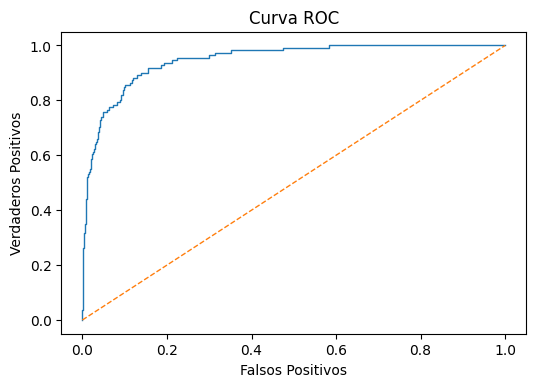

In [18]:
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

Dada la curva ROC que se forma con nuestros datos, podemos decir que el modelo es un buen predictor. Para comprobar lo anterior se espera que ROC sea cercano o superior a 0.9, lo cual comprobaremos a continuación:

In [19]:
roc_auc_score(y_test, yhat_1)

0.9481014410459379

Como podemos apreciar con un puntaje de 0.95 de ROC, nuestro modelo es un buen predictor. Ademas él modelo tiene una precisión del 77%, lo que significa que se equivoca en menos del 23% de las ocasiones.

Respecto de su exahustividad (Recall) con un valor de 29%, el modelo en este punto es bastante debil, ya que solo va a encontrar al 29% de los morosos.
